C:\Users\1\AppData\Local\Temp\ipykernel_2144\3914273054.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['num'], palette="viridis")


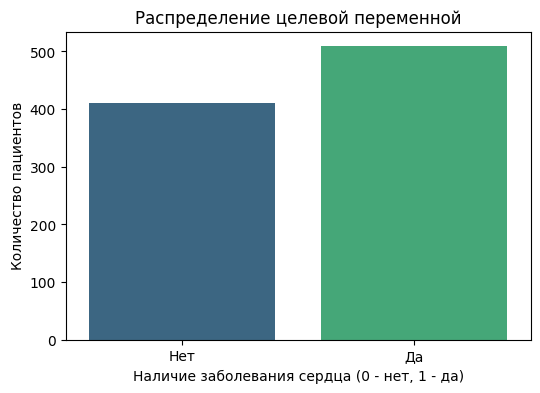

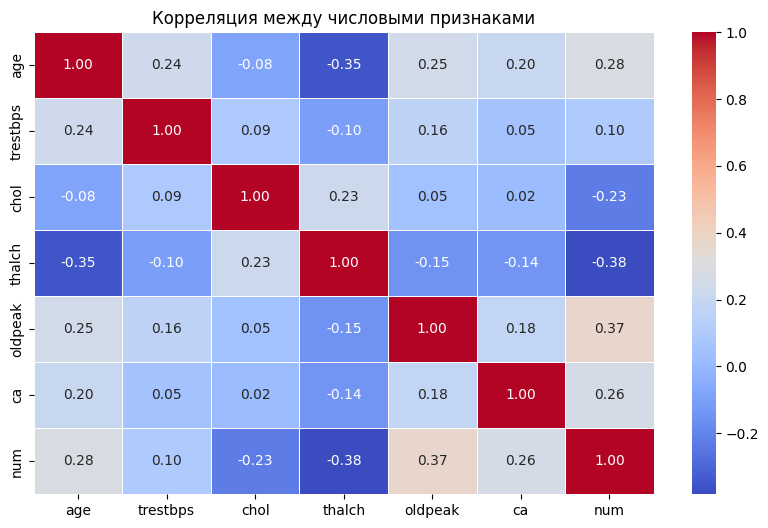

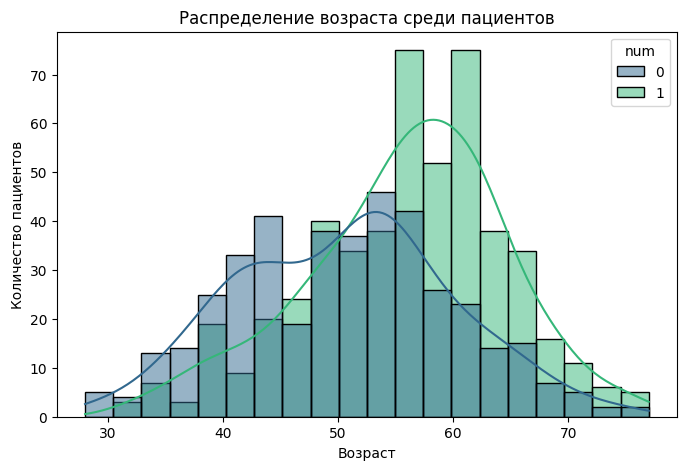


📊 Model Performance Metrics:
Accuracy: 0.8533
Precision: 0.8571
Recall: 0.8824
F1 Score: 0.8696
ROC AUC Score: 0.9238


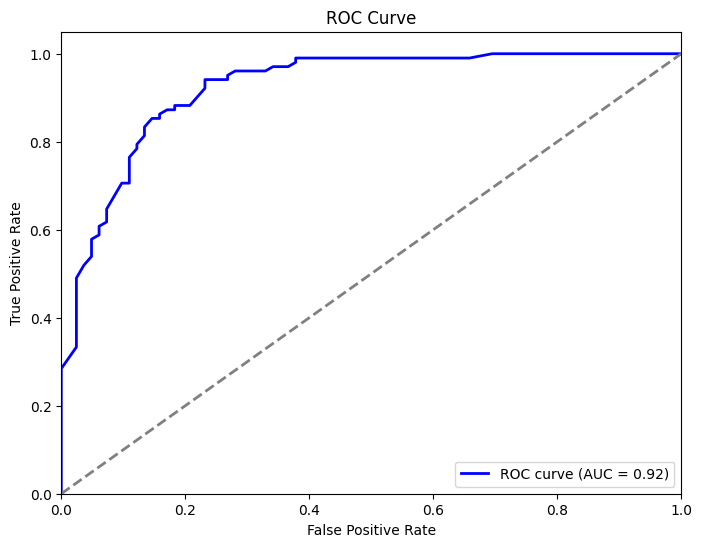

C:\Users\1\AppData\Local\Temp\ipykernel_2144\3914273054.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_names, palette="viridis")


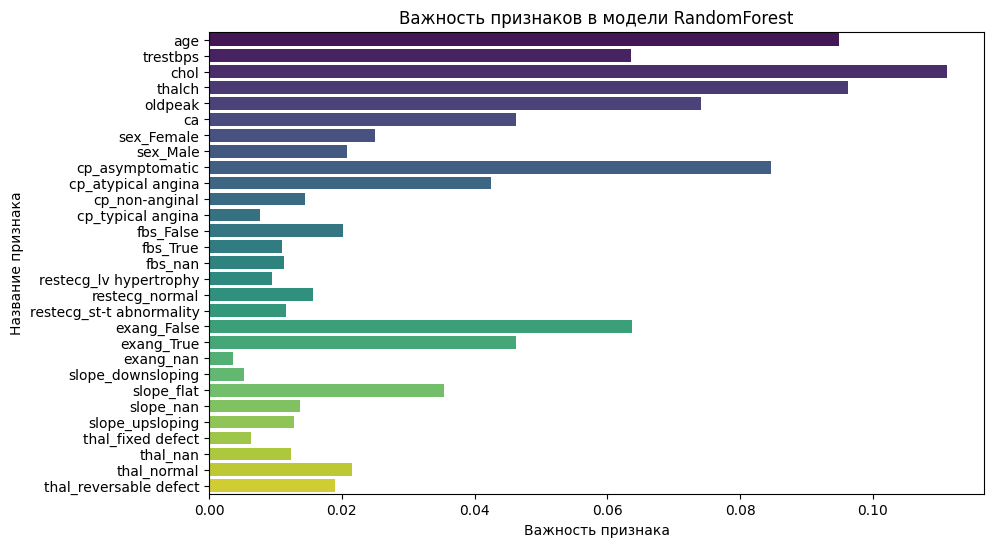

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Загрузка данных
file_path = "heart_disease_uci.csv"  # Укажите путь к файлу
df = pd.read_csv(file_path)

# Функция очистки данных
def clean_dataframe(df):
    categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
    numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

    df[categorical_features] = df[categorical_features].astype(str).apply(lambda x: x.str.strip())

    imputer_num = SimpleImputer(strategy="mean")
    df[numerical_features] = imputer_num.fit_transform(df[numerical_features])

    df[categorical_features] = df[categorical_features].fillna("unknown")

    return df, numerical_features, categorical_features

# Очистка данных
df, numerical_features, categorical_features = clean_dataframe(df)

# Преобразуем целевую переменную в бинарный формат (0 - нет болезни, 1 - есть болезнь)
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# 📊 1. Гистограмма распределения целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x=df['num'], palette="viridis")
plt.xlabel("Наличие заболевания сердца (0 - нет, 1 - да)")
plt.ylabel("Количество пациентов")
plt.title("Распределение целевой переменной")
plt.xticks(ticks=[0, 1], labels=["Нет", "Да"])
plt.show()

# 📊 2. Корреляция между числовыми признаками
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_features + ['num']].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляция между числовыми признаками")
plt.show()

# 📊 3. Распределение возрастов среди больных и здоровых пациентов
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="age", hue="num", kde=True, palette="viridis", bins=20)
plt.xlabel("Возраст")
plt.ylabel("Количество пациентов")
plt.title("Распределение возраста среди пациентов")
plt.show()

# Разделение данных
X = df.drop(columns=['id', 'origin', 'num'])
y = df['num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Преобразование данных
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Обучение модели
model = RandomForestClassifier(n_estimators=100, random_state=42)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

# Предсказания
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Метрики качества модели
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred),
    "ROC AUC Score": roc_auc_score(y_test, y_proba)
}

print("\n📊 Model Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# 📊 4. ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 📊 5. Важность признаков
feature_importances = model.feature_importances_

# Получаем названия признаков
cat_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_feature_names)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_names, palette="viridis")
plt.xlabel("Важность признака")
plt.ylabel("Название признака")
plt.title("Важность признаков в модели RandomForest")
plt.show()
